In [12]:
from config import DATA

import sys
import time
import pickle
import warnings
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from pgm.data import SequenceStructureData
from pgm.layers import GaussianLayer, OneHotLayer
from pgm.edge import Edge
from pgm.model import MRF

from structure.model import ConvNet

from meg.loss import PatternMatchingLoss
from meg.meg import MaximumEntropyGenerator
from meg.model import Energy, Entropy, Generator

ROOT = "/home/malbranke/"
sys.path.append(f"{ROOT}")

device = torch.device('cpu')
warnings.filterwarnings("ignore")
torch.cuda.is_available()

False

In [2]:
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
DATASET = "PF00397"
q = 21

## Data

In [3]:
train_dataset = SequenceStructureData(f"{DATA}/{DATASET}", dataset="train")
train_loader = DataLoader(train_dataset, batch_size = 100, 
                          shuffle = True, drop_last = True)

val_dataset = SequenceStructureData(f"{DATA}/{DATASET}", dataset="val")
val_loader = DataLoader(val_dataset, batch_size = 100, drop_last = True)

N, qv = train_dataset.raw_sequences.shape[1], train_dataset.raw_sequences.shape[2]
qs = train_dataset.ss_sequences.shape[2]
Nt, qt = train_dataset.ss_transitions.shape[1], train_dataset.ss_transitions.shape[2]

In [4]:
pots = np.zeros((train_dataset.raw_sequences.shape[1], train_dataset.raw_sequences.shape[2]))
for w, v in zip(train_dataset.weights,train_dataset.raw_sequences):
    pots += w*v
pots /= np.sum(train_dataset.weights)
pots = pots.T
pots = torch.FloatTensor((pots.T-np.mean(pots, 1)).T).view(-1).to(device)

In [5]:
HMM = torch.load(f"{DATA}/{DATASET}/hmm.pt")

In [6]:
qx, qs = 40, 3
model_ss3 = ConvNet(qx, qs)
model_ss3 = model_ss3.to(device)
model_ss3.load_state_dict(torch.load(f"{DATA}/secondary_structure/model_40feats.h5"))
model_ss3.eval()

ConvNet(
  (conv1): ResBlock(
    (conv_1): ConvBlock(
      (conv): Conv1d(40, 100, kernel_size=(11,), stride=(1,), padding=(5,))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): ConvBlock(
      (conv): Conv1d(40, 100, kernel_size=(1,), stride=(1,))
      (normalization): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv2): ResBlock(
    (conv_1): ConvBlock(
      (conv): Conv1d(100, 100, kernel_size=(11,), stride=(1,), padding=(5,))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): ConvBlock(
      (conv): Conv1d(100, 100, kernel_size=(1,), stride=(1,))
      (normalization): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv3): ResBlock(
    (c

In [7]:
n_patterns, c_patterns, _ =  pickle.load(open(f"{DATA}/{DATASET}/patterns.pkl","rb"))
regexes = []
for x in n_patterns:
    if len(x):
        regexes.append([(i,None,None) for i in x])
Q,T,pi = pickle.load(open(f"{DATA}/secondary_structure/statistics.pkl", "rb"))
T = torch.zeros(*T.shape)
inf = float("Inf")
x, y, z, t = np.where(Q > -inf)
Q[x,y,z,t] = 0

In [8]:
matcher = PatternMatchingLoss(model_ss3, 
                              pattern = regexes[0], 
                              Q = Q, hmm = HMM)

## Model

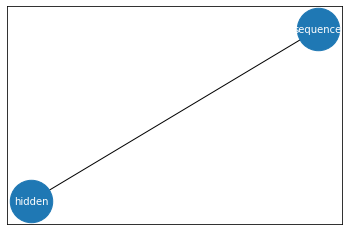

12.781778335571289

In [9]:
visible_layers = ["sequence"]
hidden_layers = ["hidden"]

v = OneHotLayer(pots, N=N, q=qv, name="sequence")
h = GaussianLayer(N=200, name="hidden")

E = [(v.name, h.name)]

ebm = MRF(layers={v.name: v,
                    h.name: h},
            edges=E).to(device)

for visible in visible_layers:
    edge = ebm.get_edge(visible, "hidden")
    edge.gauge = edge.gauge.to(device)
    
ebm.load(f"{DATA}/{DATASET}/weights/seq-reg-200_1290.h5")
ebm.ais()

In [10]:
import torch
from torch import nn, optim
from torch.nn import functional as F

from structure.model import leaky_relu, ConvBlock

class Entropy(nn.Module):
    def __init__(self, q, N, h):
        super(Entropy, self).__init__()
        self.q, self.N = q, N
        self.bilinear = nn.Bilinear(q*N, h, 1)


    def forward(self, x, h):
        return self.bilinear(x,h)

class Generator(nn.Module):
    def __init__(self, q, N, z_dim):
        super(Generator, self).__init__()
        self.q, self.N = q, N
        self.z_dim = z_dim
        self.linear = nn.Linear(z_dim, q*16*4)
        self.conv1 = ConvBlock(nn.ConvTranspose1d, leaky_relu, nn.BatchNorm1d,
                               4*q, 2*q, kernel_size = 11, stride = 2, padding = 5, output_padding = 1)
        self.conv2 = ConvBlock(nn.ConvTranspose1d, leaky_relu, nn.BatchNorm1d,
                               2*q, q, kernel_size = 11, stride = 2, padding = 3, output_padding = 1)
        
    def forward(self, h):
        h = self.linear(h).view(-1, 4*self.q, 16)
        h = self.conv1(h)
        h = self.conv2(h)
        return F.softmax(h, 1).view(-1, self.q * self.N)
    
class Energy(nn.Module):
    def __init__(self, ebm, q, N, matcher = None):
        super(Energy, self).__init__()
        self.ebm = ebm
        self.q, self.N = q, N
        self.matcher = matcher
        self.use_ssqa = False
        
    def forward(self, x):
        d =  {"sequence":x}
        seq = -(self.ebm.integrate_likelihood(d, "hidden")/self.N - self.ebm.Z) 
        if self.matcher and self.use_ssqa:
            struct = -self.matcher(x)
        else:
            struct = torch.tensor(0.)
        return seq + 10 * struct, seq.mean(), struct.mean()

In [13]:
class Energy(nn.Module):
    def __init__(self, ebm, q, N, matcher = None):
        super(Energy, self).__init__()
        self.ebm = ebm
        self.q, self.N = q, N
        self.matcher = matcher
        self.use_ssqa = False
        
    def forward(self, x):
        d =  {"sequence":x}
        seq = -(self.ebm.integrate_likelihood(d, "hidden")/self.N - self.ebm.Z) 
        if self.matcher and self.use_ssqa:
            struct = -self.matcher(x)
        else:
            struct = torch.tensor(0.)
        return seq + 10 * struct, seq.mean(), struct.mean()

In [14]:
name = "meg_ssqa_Dense"
G = Generator(q, N, 200)
H = Entropy(q, N, 200)
E = Energy(ebm, q, N, matcher)
meg = MaximumEntropyGenerator(E, G, H, f"{DATA}/{DATASET}/meg/logs/{name}")
#meg.load(f"{DATA}/{DATASET}/meg/weights.h5")

In [15]:
E.use_ssqa = True

In [ ]:
for _ in range(0, 1000000):
    logs = meg.train_generator(batch_size = 16)
    print(f"It {logs[-1]} || D = {logs[0]:.3f} || E_seq = {logs[2]:.3f} || E_ssqa = {logs[3]:.3f} || I(JSD) = {logs[1]:.3f}", end="\r")

In [18]:
meg.g_hist

[]

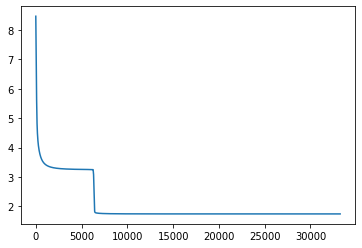

In [18]:
g_costs = torch.tensor(g_costs)
plt.plot([g_costs[i:i+100,2].mean() for i in range(len(g_costs)-100)]) 
plt.show()

In [27]:
E.use_ssqa = True
#E.matcher = matcher
meg.save(f"{DATA}/{DATASET}/meg/weights.h5")

In [28]:
x = meg.generate(2000).detach().view(2000, q, -1)

In [29]:
hard_x = torch.zeros(*x.size())
for i,x_ in enumerate(x):
    hard_x[i, x_.argmax(0), torch.arange(x.size(-1))] = 1

In [31]:
torch.save(hard_x, f"{DATA}/{DATASET}/gen_data/meg_with_matching_better.pt")

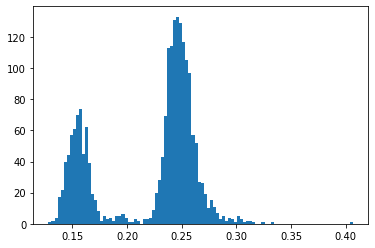

In [33]:
plt.hist(-matcher(hard_x).detach(), bins = 100)
plt.show()

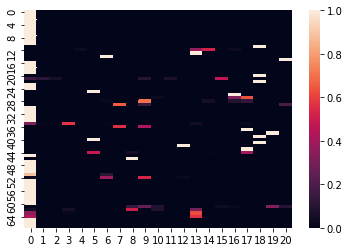

In [34]:
import seaborn as sns
sns.heatmap(hard_x.mean(0).T)